#  **ECE 533- FINE TUNIN CREMA-D USING R2Plus1D_18**

# New Section

 Colab mounts your personal Google Drive into the notebook’s virtual file system at the folder path /content/drive. Everything inside your Drive then appears under that directory, so you can read and write files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Dependencies

In [ ]:
!pip install torch==2.1.0
!pip install torchvision==0.16.0
!pip install torchaudio==2.7.0
!pip install pytorchvideo==0.1.5
!pip install numpy==1.26.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Preparing Data for Model, changing .flv to mp4

This script organizes raw CREMA‑D video clips by emotion and converts them from FLV to efficient H.264/AAC MP4s. It first defines the source folder, target root, and the six emotion codes, then creates matching sub‑directories (e.g., crema_preprocessed/ANG). It scans the source for every .flv, reads the emotion code embedded in each filename, and—if it’s one of the six—invokes FFmpeg with a fast, quality‑balanced preset (libx264, crf 22, aac) to transcode the file, saving it into the correct emotion folder. A tqdm progress bar tracks the process while console output is suppressed, yielding a neatly organized, ready‑to‑use MP4 dataset.











In [ ]:
import os
import glob
import subprocess
from tqdm import tqdm

# -------------------------
# Configuration
# -------------------------
SOURCE_DIR = "/content/gdrive/MyDrive/crema-d-mirror/VideoFlash"  # Path to raw .flv videos
TARGET_DIR = "crema_preprocessed"  # Output path
EMOTION_CODES = ["NEU", "HAP", "SAD", "ANG", "DIS", "FEA"]

# Create output structure
for code in EMOTION_CODES:
    os.makedirs(os.path.join(TARGET_DIR, code), exist_ok=True)

# -------------------------
# Process and convert videos
# -------------------------
video_paths = glob.glob(os.path.join(SOURCE_DIR, "*.flv"))

for path in tqdm(video_paths, desc="Converting and organizing CREMA-D"):
    filename = os.path.basename(path)
    parts = filename.split("_")

    if len(parts) >= 3:
        emotion_code = parts[2]
        if emotion_code in EMOTION_CODES:
            output_dir = os.path.join(TARGET_DIR, emotion_code)
            output_path = os.path.join(output_dir, filename.replace(".flv", ".mp4"))

            # FFmpeg command to convert .flv to .mp4
            cmd = [
                "ffmpeg", "-y", "-i", path,
                "-c:v", "libx264", "-preset", "fast", "-crf", "22",
                "-c:a", "aac", "-strict", "experimental",
                output_path
            ]
            subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)


Converting and organizing CREMA-D: 100%|██████████| 7442/7442 [47:00<00:00,  2.64it/s]


#**R2Plus1D-18**
R2Plus1D-18 is a video-classification network that keeps the familiar 18-layer ResNet backbone but replaces every 3-D convolution with a two-step “(2 + 1)D” block: a 2-D spatial kernel (height × width) followed by a 1-D temporal kernel (time). This factorization cuts the parameter count compared with a full 3-D filter, injects an extra ReLU non-linearity between the spatial and temporal stages, and therefore allows deeper, more expressive decision functions while training faster and using less memory. Stacking these blocks in the standard ResNet pattern (conv-stem → four residual stages → global spatiotemporal pooling → fully-connected layer) yields a compact model that can be pretrained on large video sets such as Kinetics-400 and fine-tuned for downstream action-recognition or video-understanding tasks. Empirically, the architecture outperforms vanilla 3-D CNNs of comparable depth on Kinetics and Sports-1M while staying lighter and easier to optimize.

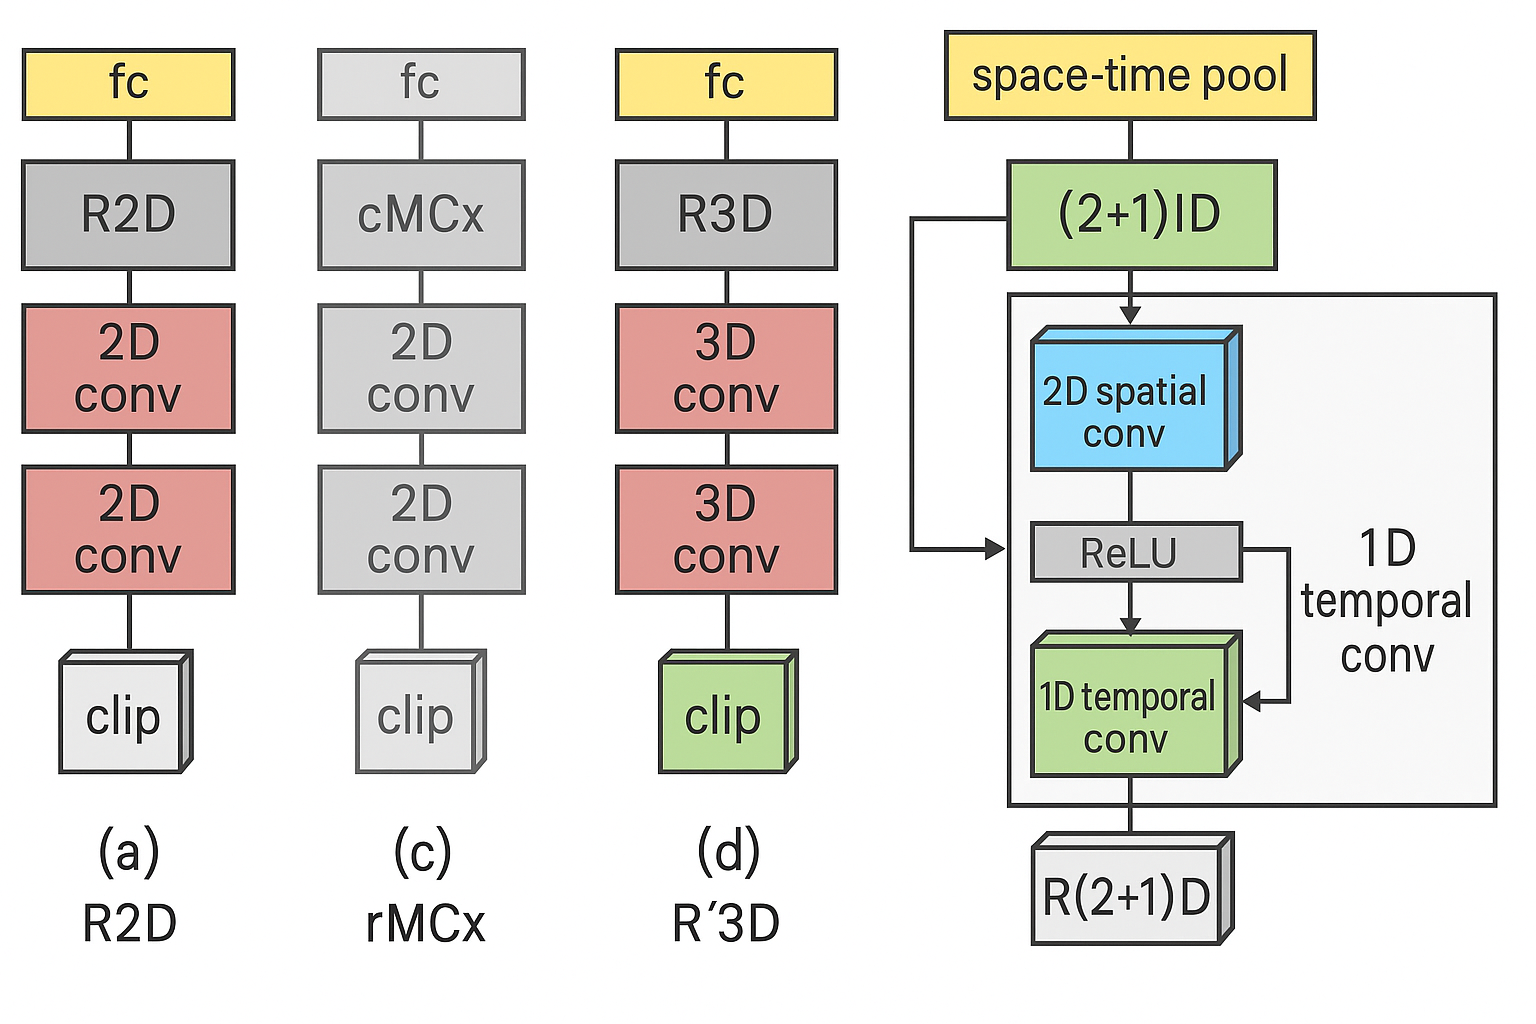

In [ ]:
#!/usr/bin/env python3
"""
Explain the R(2+1)D-18 video-classification model layer by layer.

Usage:
    python explain_r2plus1d18.py
"""

import torch
import torch.nn as nn
from torchvision.models.video import r2plus1d_18

# ------------------------------------------
# Helper: nice, one-line description per layer type
# ------------------------------------------
def describe(module: nn.Module) -> str:
    if isinstance(module, nn.Conv3d):
        return ("3-D convolution\n"
                f" └─kernel={module.kernel_size}, stride={module.stride}, padding={module.padding}")
    if isinstance(module, nn.Conv2d):
        return ("2-D convolution\n"
                f" └─kernel={module.kernel_size}, stride={module.stride}, padding={module.padding}")
    if isinstance(module, nn.BatchNorm3d):
        return "Batch-norm (3-D) → stabilises activations"
    if isinstance(module, nn.BatchNorm2d):
        return "Batch-norm (2-D) → stabilises activations"
    if isinstance(module, nn.ReLU):
        return "ReLU non-linearity"
    if isinstance(module, nn.AdaptiveAvgPool3d):
        return "Adaptive avg-pool → reduces to 1×1×1"
    if isinstance(module, nn.MaxPool3d):
        return ("Max-pool (3-D) → down-samples feature map\n"
                f" └─kernel={module.kernel_size}, stride={module.stride}")
    if isinstance(module, nn.Linear):
        return f"Fully connected → outputs {module.out_features} classes"
    # default
    return module.__class__.__name__

# ------------------------------------------
# Build model
# ------------------------------------------
device = "cpu"  # set to "cuda" if you have a GPU
model = r2plus1d_18(weights="KINETICS400_V1").to(device).eval()

# ------------------------------------------
# Register hooks to record output shapes
# ------------------------------------------
layer_info = []   # (ordinal, name, class, shape, text)

def hook(name):
    def _hook(module, inp, out):
        # out is a tensor for most layers
        shape = tuple(out.shape) if isinstance(out, torch.Tensor) else str(out)
        layer_info.append((len(layer_info), name, module.__class__.__name__, shape,
                           describe(module)))
    return _hook

for name, module in model.named_modules():
    # skip the root module ("") to avoid duplicate entry
    if name:
        module.register_forward_hook(hook(name))

# ------------------------------------------
# Dummy forward pass (1 clip, 3×16×112×112)
# ------------------------------------------
dummy = torch.randn(1, 3, 16, 112, 112).to(device)
with torch.no_grad():
    _ = model(dummy)

# ------------------------------------------
# Pretty-print the results
# ------------------------------------------
print("=" * 80)
print("R(2+1)D-18 architecture explanation\n")
for idx, name, cls, shape, text in layer_info:
    indent = "  " * name.count(".")  # indent by depth in module tree
    print(f"{idx:03d}. {indent}{name}  ({cls})")
    print(f"{' '*7}{indent}output shape: {shape}")
    for line in text.splitlines():
        print(f"{' '*7}{indent}{line}")
    print()
print("=" * 80)


/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


100%|██████████| 120M/120M [00:02<00:00, 47.3MB/s]


R(2+1)D-18 architecture explanation

000.   stem.0  (Conv3d)
         output shape: (1, 45, 16, 56, 56)
         3-D convolution
          └─kernel=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3)

001.   stem.1  (BatchNorm3d)
         output shape: (1, 45, 16, 56, 56)
         Batch-norm (3-D) → stabilises activations

002.   stem.2  (ReLU)
         output shape: (1, 45, 16, 56, 56)
         ReLU non-linearity

003.   stem.3  (Conv3d)
         output shape: (1, 64, 16, 56, 56)
         3-D convolution
          └─kernel=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0)

004.   stem.4  (BatchNorm3d)
         output shape: (1, 64, 16, 56, 56)
         Batch-norm (3-D) → stabilises activations

005.   stem.5  (ReLU)
         output shape: (1, 64, 16, 56, 56)
         ReLU non-linearity

006. stem  (R2Plus1dStem)
       output shape: (1, 64, 16, 56, 56)
       R2Plus1dStem

007.         layer1.0.conv1.0.0  (Conv3d)
               output shape: (1, 144, 16, 56, 56)
               3-D convolutio

##**Designing Inputs for Model**
The pipeline converts each raw clip into a standardized 3 × 16 × 112 × 112 float tensor ready for TorchVision video models. It first picks 16 evenly spaced frames, resizes them so the shorter edge is 128 px, and center-crops a 112 × 112 patch to match the spatial resolution expected by pretrained networks. Temporary dimension swaps let the crop operate on a [T, C, H, W] layout, after which the data returns to [C, T, H, W], is cast to float32, and each frame is normalized with the Kinetics-400 RGB mean 0.45 and std 0.225. This sequence preserves the clip’s global motion while enforcing uniform length, size, and distribution for efficient inference with models like R(2 + 1)D-18.

In [ ]:
import os
import glob
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from torchvision.transforms import CenterCrop
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    UniformTemporalSubsample,
    ShortSideScale,
    UniformCropVideo
)
from torchvision.transforms import Compose, Normalize
import torch.nn.functional as F

# -------------------------
# Config
# -------------------------
VIDEO_DIR = "crema_preprocessed"
BATCH_SIZE = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = sorted(os.listdir(VIDEO_DIR))
LABEL_MAP = {label: idx for idx, label in enumerate(LABELS)}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# -------------------------
# Transform with pytorchvideo
# -------------------------
video_transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(16),
        ShortSideScale(128),
        lambda x: x.permute(1, 0, 2, 3),  # [C, T, H, W] → [T, C, H, W]
        CenterCrop(112),
        lambda x: x.permute(1, 0, 2, 3),  # back to [C, T, H, W]
        lambda x: x.to(torch.float32),
        lambda x: torch.stack([torchvision.transforms.functional.normalize(f, [0.45]*3, [0.225]*3) for f in x.permute(1, 0, 2, 3)], dim=1)
,
    ])
)

# -------------------------
# Dataset class
# -------------------------
class CREMADVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label)
            for file in glob.glob(os.path.join(class_dir, "*.mp4")):
                self.samples.append((file, LABEL_MAP[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
      path, label = self.samples[idx]

      try:
          video = EncodedVideo.from_path(path)
          clip_data = video.get_clip(0, 2.0)
          if clip_data is None or clip_data.get("video") is None:
              raise ValueError("Failed to decode video.")
          clip = clip_data["video"] / 255.0
      except Exception as e:
          print(f"⚠️ Skipping file: {path} due to error: {e}")
          # Return a dummy black clip and label (or raise to skip entirely)
          dummy = torch.zeros(3, 16, 112, 112)  # [C, T, H, W]
          return dummy, label, path

      sample = {"video": clip}
      if self.transform:
          sample = self.transform(sample)

      return sample["video"], label, path


# -------------------------
# Load dataset
# -------------------------
dataset = CREMADVideoDataset(VIDEO_DIR, transform=video_transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# Load pretrained ResNet-style video model
# -------------------------
weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights).to(DEVICE).eval()

# -------------------------
# Inference + Visualization
# -------------------------
with torch.no_grad():
    for i, (videos, labels, paths) in enumerate(loader):
        videos = videos.to(DEVICE)
        outputs = model(videos)
        preds = torch.argmax(outputs, dim=1)

        pred_class = INV_LABEL_MAP.get(preds.item(), "Unknown")
        true_class = INV_LABEL_MAP.get(labels.item(), "Unknown")

        # Unnormalize & visualize
        video_clip = videos[0].cpu()
        video_clip = (video_clip * 0.225 + 0.45).clamp(0, 1)
        video_clip = (video_clip * 255).byte()

        T = video_clip.shape[1]
        fig, axes = plt.subplots(1, T, figsize=(T * 1.5, 3))
        for t in range(T):
            frame = video_clip[:, t, :, :].permute(1, 2, 0).numpy()
            axes[t].imshow(frame)
            axes[t].axis("off")
        fig.suptitle(f"🎯 Predicted: {pred_class} | 🏷️ Actual: {true_class}", fontsize=14)
        plt.tight_layout()
        plt.show()

        if i >= 4:
            break


Output hidden; open in https://colab.research.google.com to view.

##**Design Training Loop**
The script fine-tunes a pretrained R(2 + 1)D-18 video-classification network on the CREMA-D emotion dataset. It first defines a Kinetics-style preprocessing pipeline that (for each .mp4) uniformly samples 16 frames, rescales, center-crops to 112 × 112, converts to float, and normalizes with Kinetics RGB statistics. A custom CREMADVideoDataset iterates through the crema_preprocessed/ directory, returning the processed clip tensor and its emotion label; the dataset is split 80 : 20 into training and validation subsets and loaded in mini-batches. The model’s final fully-connected layer is replaced to match the number of emotion classes, then the network is trained for five epochs on GPU (if available) using Adam and cross-entropy loss while tracking per-epoch loss and accuracy. After each epoch the script evaluates on the validation set, prints summary metrics, and finally plots the training-loss curve alongside training and validation accuracy curves for quick diagnostic visualization.

[Epoch 1] Loss: 1871.2003 | Train Acc: 0.5075 | Val Acc: 0.6615
[Epoch 2] Loss: 1268.9001 | Train Acc: 0.6869 | Val Acc: 0.7038
[Epoch 3] Loss: 948.0980 | Train Acc: 0.7685 | Val Acc: 0.6897
[Epoch 4] Loss: 684.5238 | Train Acc: 0.8394 | Val Acc: 0.7871
[Epoch 5] Loss: 489.7206 | Train Acc: 0.8873 | Val Acc: 0.7670


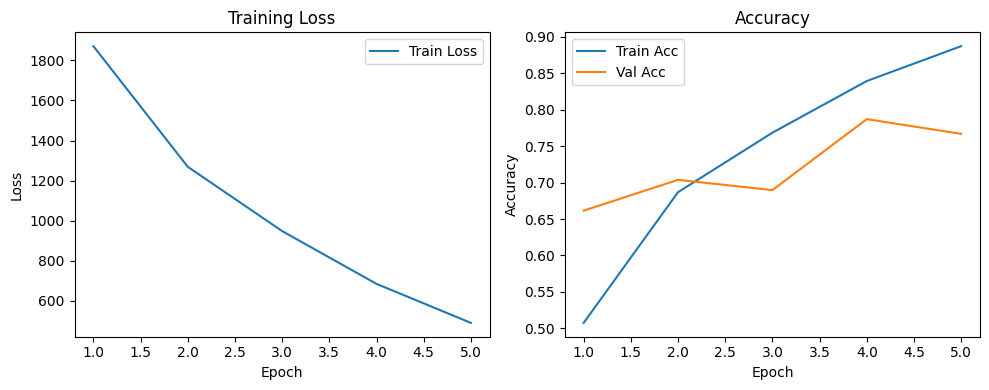

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    UniformTemporalSubsample,
    ShortSideScale
)
from torchvision.transforms import Compose, CenterCrop
from torchvision.transforms.functional import normalize

# -------------------------
# Config
# -------------------------
VIDEO_DIR = "crema_preprocessed"
BATCH_SIZE = 4
EPOCHS = 5
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = sorted(os.listdir(VIDEO_DIR))
LABEL_MAP = {label: idx for idx, label in enumerate(LABELS)}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# -------------------------
# Transform with pytorchvideo
# -------------------------
video_transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(16),
        ShortSideScale(128),
        lambda x: x.permute(1, 0, 2, 3),
        CenterCrop(112),
        lambda x: x.permute(1, 0, 2, 3),
        lambda x: x.to(torch.float32),
        lambda x: torch.stack([
            normalize(f, [0.45] * 3, [0.225] * 3) for f in x.permute(1, 0, 2, 3)
        ], dim=1)
    ])
)

# -------------------------
# Dataset class
# -------------------------
class CREMADVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label)
            for file in glob.glob(os.path.join(class_dir, "*.mp4")):
                self.samples.append((file, LABEL_MAP[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            video = EncodedVideo.from_path(path)
            clip = video.get_clip(0, 2.0)["video"] / 255.0
            sample = {"video": clip}
            if self.transform:
                sample = self.transform(sample)
            return sample["video"], label
        except:
            dummy = torch.zeros(3, 16, 112, 112)
            return dummy, label

# -------------------------
# Load dataset
# -------------------------
dataset = CREMADVideoDataset(VIDEO_DIR, transform=video_transform)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# -------------------------
# Load model for fine-tuning
# -------------------------
weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))  # Replace classifier head
model = model.to(DEVICE)

# -------------------------
# Training loop with validation tracking
# -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)
        outputs = model(videos)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(total_loss)
    train_accuracies.append(train_acc)

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(videos)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# -------------------------
# Plot validation curves
# -------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Train Acc')
plt.plot(range(1, EPOCHS+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


##**Looking for best parameters**
The script performs a brute-force grid search to find the best learning-rate / batch-size combination for fine-tuning a pretrained R(2 + 1)D-18 video model on the CREMA-D emotion dataset. It first defines a Kinetics-style preprocessing pipeline (16 uniformly sampled frames, 112 × 112 center crop, RGB normalization), then builds a CREMADVideoDataset that reads each .mp4, applies the transform, and pairs the clip with its emotion label. For every (lr, batch) pair in the grid it: (1) splits the dataset 80 / 20 into train and validation subsets, (2) replaces the model’s classifier head to match the six emotions, (3) trains for three epochs on GPU/CPU with Adam and cross-entropy loss, and (4) records the final validation accuracy. After trying all parameter combinations it reports the highest-scoring setting, giving a quick empirical tuning of batch size and learning rate for this specific fine-tuning task.

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    UniformTemporalSubsample,
    ShortSideScale
)
from torchvision.transforms import Compose, CenterCrop
from torchvision.transforms.functional import normalize
from sklearn.model_selection import ParameterGrid

# -------------------------
# Config
# -------------------------
VIDEO_DIR = "crema_preprocessed"
EPOCHS = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = sorted(os.listdir(VIDEO_DIR))
LABEL_MAP = {label: idx for idx, label in enumerate(LABELS)}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# -------------------------
# Transform with pytorchvideo
# -------------------------
video_transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(16),
        ShortSideScale(128),
        lambda x: x.permute(1, 0, 2, 3),
        CenterCrop(112),
        lambda x: x.permute(1, 0, 2, 3),
        lambda x: x.to(torch.float32),
        lambda x: torch.stack([
            normalize(f, [0.45] * 3, [0.225] * 3) for f in x.permute(1, 0, 2, 3)
        ], dim=1)
    ])
)

# -------------------------
# Dataset class
# -------------------------
class CREMADVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label)
            for file in glob.glob(os.path.join(class_dir, "*.mp4")):
                self.samples.append((file, LABEL_MAP[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            video = EncodedVideo.from_path(path)
            clip = video.get_clip(0, 2.0)["video"] / 255.0
            sample = {"video": clip}
            if self.transform:
                sample = self.transform(sample)
            return sample["video"], label
        except:
            dummy = torch.zeros(3, 16, 112, 112)
            return dummy, label

# -------------------------
# Hyperparameter tuning setup
# -------------------------
def evaluate_model(learning_rate, batch_size):
    dataset = CREMADVideoDataset(VIDEO_DIR, transform=video_transform)
    train_len = int(0.8 * len(dataset))
    val_len = len(dataset) - train_len
    train_set, val_set = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    weights = R2Plus1D_18_Weights.DEFAULT
    model = r2plus1d_18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, len(LABELS))
    model = model.to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for videos, labels in train_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = train_loss / len(train_loader)
        train_acc = correct / total

        # Validation accuracy
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.to(DEVICE), labels.to(DEVICE)
                outputs = model(videos)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    return val_accuracies[-1]

# -------------------------
# Run grid search on batch size and learning rate
# -------------------------
param_grid = {
    'learning_rate': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],
    'batch_size': [4, 8, 16]
}

best_score = 0
best_params = {}

for params in ParameterGrid(param_grid):
    print(f"\n🔍 Testing with LR={params['learning_rate']} and BS={params['batch_size']}")
    acc = evaluate_model(params['learning_rate'], params['batch_size'])
    print(f"Accuracy: {acc * 100:.2f}%")
    if acc > best_score:
        best_score = acc
        best_params = params

print(f"\n🏆 Best Params: {best_params} | Accuracy: {best_score * 100:.2f}%")



🔍 Testing with LR=1e-05 and BS=4
Epoch 1: Train Loss=1.3581, Train Acc=0.4616, Val Acc=0.6541
Epoch 2: Train Loss=0.9097, Train Acc=0.6724, Val Acc=0.7629
Epoch 3: Train Loss=0.6823, Train Acc=0.7635, Val Acc=0.7811
Accuracy: 78.11%

🔍 Testing with LR=5e-05 and BS=4
Epoch 1: Train Loss=1.1982, Train Acc=0.5485, Val Acc=0.7253
Epoch 2: Train Loss=0.7785, Train Acc=0.7227, Val Acc=0.7179
Epoch 3: Train Loss=0.5503, Train Acc=0.8058, Val Acc=0.8073
Accuracy: 80.73%

🔍 Testing with LR=0.0001 and BS=4
Epoch 1: Train Loss=1.2616, Train Acc=0.5115, Val Acc=0.6347
Epoch 2: Train Loss=0.8673, Train Acc=0.6817, Val Acc=0.7220
Epoch 3: Train Loss=0.6532, Train Acc=0.7628, Val Acc=0.7931
Accuracy: 79.31%

🔍 Testing with LR=0.0005 and BS=4
Epoch 1: Train Loss=1.8114, Train Acc=0.1804, Val Acc=0.1632
Epoch 2: Train Loss=1.8025, Train Acc=0.1759, Val Acc=0.1766
Epoch 3: Train Loss=1.8044, Train Acc=0.1631, Val Acc=0.1652
Accuracy: 16.52%

🔍 Testing with LR=0.001 and BS=4
Epoch 1: Train Loss=1.8229, 

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!ls /content/drive/MyDrive

'001354753 (1).pdf'
 001354753.pdf
 20180202_083021.jpg
 Aldehydes.pptx
 ami-ihm-kaldi-chunked.py
 ami.py
 best_model2.pt
 best_modelb.pt
 best_model.pt
 Captura.JPG
 Capture.PNG
'Colab Notebooks'
'Conductivity Experiment.docx'
 crema-d-mirror
 crema_preprocessed
'Cumpleaños de Michelle.gsheet'
'Document (2).pdf'
 Dorantes_Juan_AOI.pdf
 Dorantes_Juan_AOI_pt2.pdf
 edinburghcstr
'Elections Test'
 facebook
 Final1.pdf
 Final2.pdf
 Final3.pdf
 Final4.pdf
'Getting started.pdf'
 GigaS
'HS-Reference Letter Form_Couple (1).docx'
'Ieee_blue (1).jpg'
'Ieee_blue (2).jpg'
 Ieee_blue.jpg
 IMG_1905.JPG
 IMG_20180628_145445.jpg
'Inventory Organic .xlsx'
'Journal #4 Green Group.docx'
'Journal #4 Green Group.docx.gdoc'
 kinetics-dataset
'Manduca Lab Report - Line chart 1.gsheet'
'Manduca Presentation.gslides'
 minds
 progmicrobook.pdf
 README.md
'Report for VP.gdoc'
'Results Lab Report Manduca (1).gsheet'
'Results Lab Report Manduca (2).gsheet'
'Results Lab Report Manduca.gsheet'
'Review Test Submissi

In [ ]:
!ls /content/drive/MyDrive/crema_preprocessed

ANG  DIS  FEA  HAP  NEU  SAD


##Fine tune loop using best parameter as a reference, best performance 81% accuracy.

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


100%|██████████| 120M/120M [00:00<00:00, 192MB/s]


Epoch 1: Train Loss=1.4873, Train Acc=0.4185, Val Acc=0.6096
✅ New best model saved.
Epoch 2: Train Loss=0.9369, Train Acc=0.6676, Val Acc=0.6952
✅ New best model saved.
Epoch 3: Train Loss=0.6332, Train Acc=0.7871, Val Acc=0.7515
✅ New best model saved.
Epoch 4: Train Loss=0.4318, Train Acc=0.8591, Val Acc=0.7699
✅ New best model saved.
Epoch 5: Train Loss=0.2982, Train Acc=0.9160, Val Acc=0.7842
✅ New best model saved.
Epoch 6: Train Loss=0.1991, Train Acc=0.9475, Val Acc=0.7800
Epoch 7: Train Loss=0.1316, Train Acc=0.9710, Val Acc=0.7985
✅ New best model saved.
Epoch 8: Train Loss=0.1150, Train Acc=0.9721, Val Acc=0.8044
✅ New best model saved.
Epoch 9: Train Loss=0.0878, Train Acc=0.9794, Val Acc=0.7993
Epoch 10: Train Loss=0.0679, Train Acc=0.9847, Val Acc=0.8086
✅ New best model saved.
Epoch 11: Train Loss=0.0561, Train Acc=0.9876, Val Acc=0.8136
✅ New best model saved.
Epoch 12: Train Loss=0.0527, Train Acc=0.9891, Val Acc=0.7909
Epoch 13: Train Loss=0.0468, Train Acc=0.9891, Va

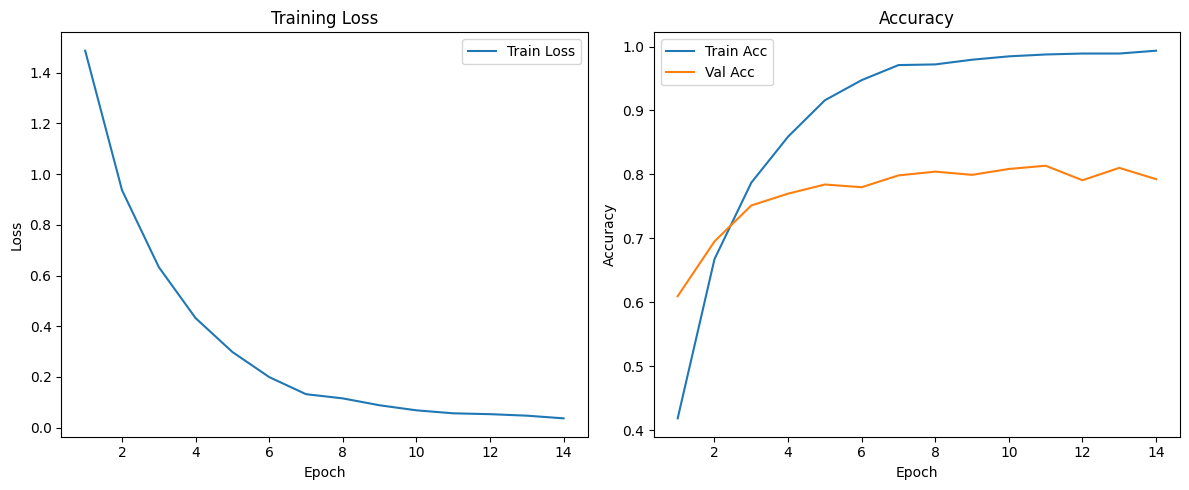

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    UniformTemporalSubsample,
    ShortSideScale
)
from torchvision.transforms import Compose, CenterCrop
from torchvision.transforms.functional import normalize

# -------------------------
# Config
# -------------------------
VIDEO_DIR = "/content/drive/MyDrive/crema_preprocessed"
EPOCHS = 15
PATIENCE = 3
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = sorted(os.listdir(VIDEO_DIR))
LABEL_MAP = {label: idx for idx, label in enumerate(LABELS)}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# -------------------------
# Transform with pytorchvideo
# -------------------------
video_transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(16),
        ShortSideScale(128),
        lambda x: x.permute(1, 0, 2, 3),
        CenterCrop(112),
        lambda x: x.permute(1, 0, 2, 3),
        lambda x: x.to(torch.float32),
        lambda x: torch.stack([
            normalize(f, [0.45] * 3, [0.225] * 3) for f in x.permute(1, 0, 2, 3)
        ], dim=1)
    ])
)

# -------------------------
# Dataset class
# -------------------------
class CREMADVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label)
            for file in glob.glob(os.path.join(class_dir, "*.mp4")):
                self.samples.append((file, LABEL_MAP[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            video = EncodedVideo.from_path(path)
            clip = video.get_clip(0, 2.0)["video"] / 255.0
            sample = {"video": clip}
            if self.transform:
                sample = self.transform(sample)
            return sample["video"], label
        except:
            dummy = torch.zeros(3, 16, 112, 112)
            return dummy, label

# -------------------------
# Train and evaluate model
# -------------------------
full_dataset = CREMADVideoDataset(VIDEO_DIR, transform=video_transform)
subset_size = int(0.80 * len(full_dataset))  # use 30% of UCF101 for fine-tuning  # use only 30% of data
subset_indices = torch.randperm(len(full_dataset))[:subset_size]
dataset = torch.utils.data.Subset(full_dataset, subset_indices)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0
patience_counter = 0


os.makedirs("/content/drive/MyDrive", exist_ok=True)
checkpoint_path = "/content/drive/MyDrive/best_model.pt"

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for videos, labels in train_loader:
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)
        outputs = model(videos)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = train_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(videos)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), checkpoint_path)
        print("✅ New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

# -------------------------
# Plot validation curves
# -------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Acc")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


#### **Changed learning rate to 5e-5, reached %84.30 accuracy and included data aumentation.**
RandomHorizontalFlip(p=0.5) is a data-augmentation transform that, with probability p (here 50 %), reflects every frame in a clip across the vertical axis—left becomes right and vice-versa. Because the flip is applied to the whole tensor at once, the temporal order stays intact: frame 0 and frame 15 are still first and last, just mirrored. This simple operation doubles the effective training set for viewpoint-symmetric categories (e.g., facial emotions or many actions) without altering clip length, resolution, or pixel statistics. By seeing each example in both its original and flipped orientations, the model learns that horizontal orientation is irrelevant to the task, which improves generalisation and reduces overfitting.

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


100%|██████████| 120M/120M [00:00<00:00, 183MB/s]


Epoch 1: Train Loss=1.1229, Train Acc=0.5640, Val Acc=0.7112
✅ New best model saved.
Epoch 2: Train Loss=0.6855, Train Acc=0.7533, Val Acc=0.6793
Epoch 3: Train Loss=0.4761, Train Acc=0.8265, Val Acc=0.7557
✅ New best model saved.
Epoch 4: Train Loss=0.3615, Train Acc=0.8734, Val Acc=0.7154
Epoch 5: Train Loss=0.2911, Train Acc=0.9000, Val Acc=0.7960
✅ New best model saved.
Epoch 6: Train Loss=0.2153, Train Acc=0.9284, Val Acc=0.7750
Epoch 7: Train Loss=0.1733, Train Acc=0.9395, Val Acc=0.7884
Epoch 8: Train Loss=0.1359, Train Acc=0.9567, Val Acc=0.7666
Epoch 9: Train Loss=0.0727, Train Acc=0.9794, Val Acc=0.8203
✅ New best model saved.
Epoch 10: Train Loss=0.0404, Train Acc=0.9882, Val Acc=0.8338
✅ New best model saved.
Epoch 11: Train Loss=0.0381, Train Acc=0.9878, Val Acc=0.8363
✅ New best model saved.
Epoch 12: Train Loss=0.0397, Train Acc=0.9889, Val Acc=0.8472
✅ New best model saved.
Epoch 13: Train Loss=0.0351, Train Acc=0.9899, Val Acc=0.8489
✅ New best model saved.
Epoch 14: T

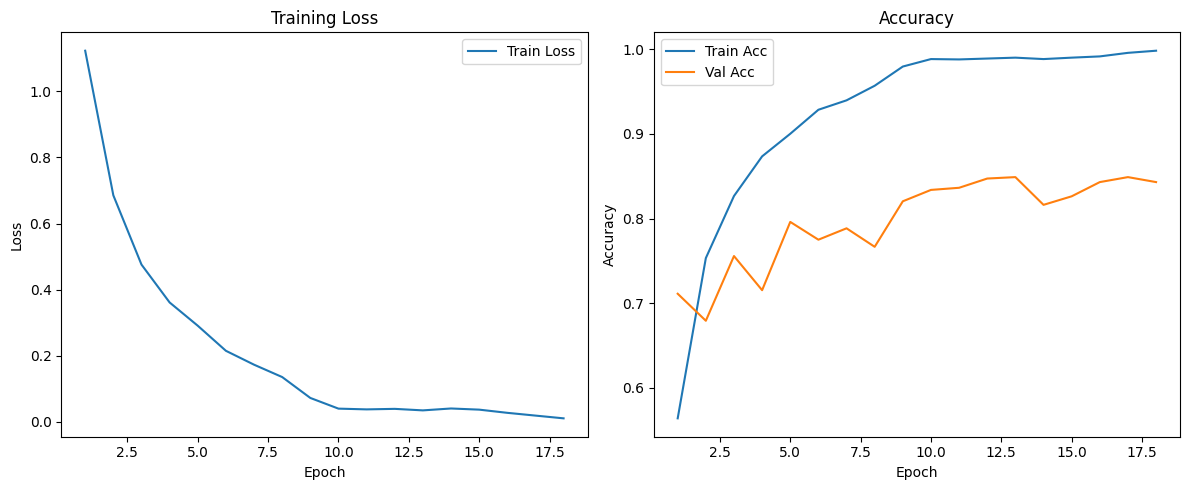

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    UniformTemporalSubsample,
    ShortSideScale
)
from torchvision.transforms import Compose, CenterCrop, RandomHorizontalFlip
from torchvision.transforms.functional import normalize

# -------------------------
# Config
# -------------------------
VIDEO_DIR = "/content/drive/MyDrive/crema_preprocessed"
EPOCHS = 20
PATIENCE = 5
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = sorted(os.listdir(VIDEO_DIR))
LABEL_MAP = {label: idx for idx, label in enumerate(LABELS)}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# -------------------------
# Transform with pytorchvideo + augment
# -------------------------
video_transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(16),
        ShortSideScale(128),
        RandomHorizontalFlip(p=0.5),
        lambda x: x.permute(1, 0, 2, 3),
        CenterCrop(112),
        lambda x: x.permute(1, 0, 2, 3),
        lambda x: x.to(torch.float32),
        lambda x: torch.stack([
            normalize(f, [0.45] * 3, [0.225] * 3) for f in x.permute(1, 0, 2, 3)
        ], dim=1)
    ])
)

# -------------------------
# Dataset class
# -------------------------
class CREMADVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label)
            for file in glob.glob(os.path.join(class_dir, "*.mp4")):
                self.samples.append((file, LABEL_MAP[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            video = EncodedVideo.from_path(path)
            clip = video.get_clip(0, 2.0)["video"] / 255.0
            sample = {"video": clip}
            if self.transform:
                sample = self.transform(sample)
            return sample["video"], label
        except:
            dummy = torch.zeros(3, 16, 112, 112)
            return dummy, label

# -------------------------
# Train and evaluate model
# -------------------------
full_dataset = CREMADVideoDataset(VIDEO_DIR, transform=video_transform)
subset_size = int(0.80 * len(full_dataset))
subset_indices = torch.randperm(len(full_dataset))[:subset_size]
dataset = torch.utils.data.Subset(full_dataset, subset_indices)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0
patience_counter = 0

os.makedirs("/content/drive/MyDrive", exist_ok=True)
checkpoint_path = "/content/drive/MyDrive/best_modelb.pt"

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for videos, labels in train_loader:
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)
        outputs = model(videos)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = train_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(videos)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), checkpoint_path)
        print("✅ New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

# -------------------------
# Plot validation curves
# -------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Acc")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Keep previous parameters and use the Full dataset, reached %85 accuracy.

Epoch 1: Train Loss=1.0702, Train Acc=0.5842, Val Acc=0.6991
✅ New best model saved.
Epoch 2: Train Loss=0.6253, Train Acc=0.7714, Val Acc=0.7683
✅ New best model saved.
Epoch 3: Train Loss=0.4709, Train Acc=0.8283, Val Acc=0.7864
✅ New best model saved.
Epoch 4: Train Loss=0.3401, Train Acc=0.8833, Val Acc=0.8113
✅ New best model saved.
Epoch 5: Train Loss=0.2526, Train Acc=0.9133, Val Acc=0.7945
Epoch 6: Train Loss=0.2178, Train Acc=0.9289, Val Acc=0.7958
Epoch 7: Train Loss=0.1655, Train Acc=0.9461, Val Acc=0.7837
Epoch 8: Train Loss=0.0979, Train Acc=0.9704, Val Acc=0.8375
✅ New best model saved.
Epoch 9: Train Loss=0.0629, Train Acc=0.9847, Val Acc=0.8301
Epoch 10: Train Loss=0.0534, Train Acc=0.9837, Val Acc=0.8294
Epoch 11: Train Loss=0.0358, Train Acc=0.9914, Val Acc=0.8449
✅ New best model saved.
Epoch 12: Train Loss=0.0502, Train Acc=0.9859, Val Acc=0.8428
Epoch 13: Train Loss=0.0491, Train Acc=0.9869, Val Acc=0.8180
Epoch 14: Train Loss=0.0484, Train Acc=0.9869, Val Acc=0.83

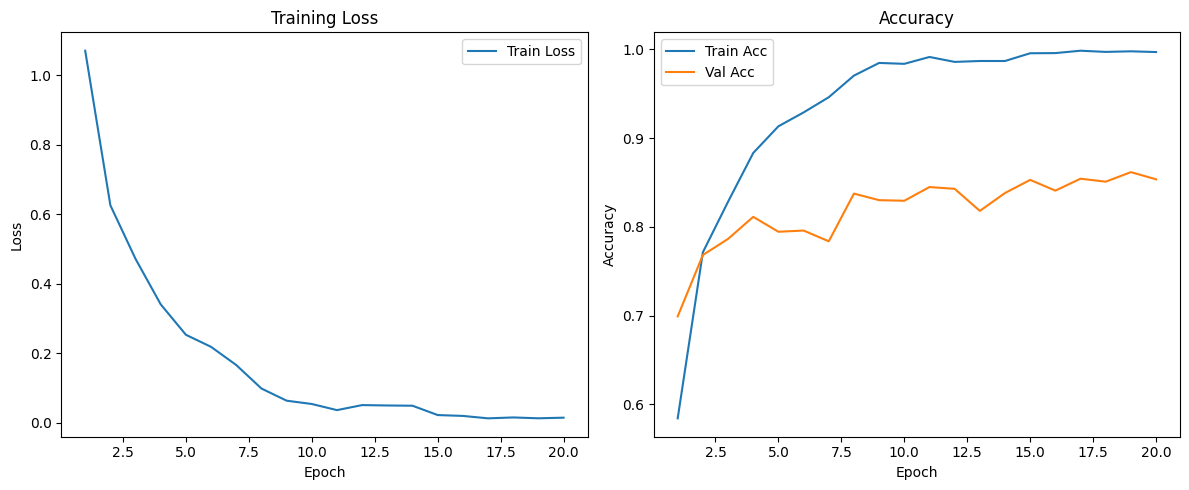

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    UniformTemporalSubsample,
    ShortSideScale
)
from torchvision.transforms import Compose, CenterCrop, RandomHorizontalFlip, ColorJitter, RandomResizedCrop
from torchvision.transforms.functional import normalize

# -------------------------
# Config
# -------------------------
VIDEO_DIR = "/content/drive/MyDrive/crema_preprocessed"
EPOCHS = 20
PATIENCE = 5
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = sorted(os.listdir(VIDEO_DIR))
LABEL_MAP = {label: idx for idx, label in enumerate(LABELS)}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# -------------------------
# Transform with pytorchvideo + augment
# -------------------------
video_transform = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(16),
        ShortSideScale(128),
        RandomHorizontalFlip(p=0.5),
        lambda x: x.permute(1, 0, 2, 3),
        CenterCrop(112),
        lambda x: x.permute(1, 0, 2, 3),
        lambda x: x.to(torch.float32),
        lambda x: torch.stack([
            normalize(f, [0.45] * 3, [0.225] * 3) for f in x.permute(1, 0, 2, 3)
        ], dim=1)
    ])
)

# -------------------------
# Dataset class
# -------------------------
class CREMADVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label)
            for file in glob.glob(os.path.join(class_dir, "*.mp4")):
                self.samples.append((file, LABEL_MAP[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            video = EncodedVideo.from_path(path)
            clip = video.get_clip(0, 2.0)["video"] / 255.0
            sample = {"video": clip}
            if self.transform:
                sample = self.transform(sample)
            return sample["video"], label
        except:
            dummy = torch.zeros(3, 16, 112, 112)
            return dummy, label

# -------------------------
# Train and evaluate model
# -------------------------
full_dataset = CREMADVideoDataset(VIDEO_DIR, transform=video_transform)
subset_size = len(full_dataset)  # Use full dataset
subset_indices = torch.randperm(len(full_dataset))[:subset_size]
dataset = torch.utils.data.Subset(full_dataset, subset_indices)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))
model = model.to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0
patience_counter = 0

os.makedirs("/content/drive/MyDrive", exist_ok=True)
checkpoint_path = "/content/drive/MyDrive/best_model1c.pt"

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for videos, labels in train_loader:
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)
        outputs = model(videos)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = train_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(videos)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), checkpoint_path)
        print("✅ New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

# -------------------------
# Plot validation curves
# -------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Acc")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


###Evaluate Model with different inputs

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


100%|██████████| 120M/120M [00:00<00:00, 195MB/s]


Epoch 01: loss 1.1005 | train 57.113% | val 63.978%
   ✅ new best saved
Epoch 02: loss 0.6515 | train 76.253% | val 77.599%
   ✅ new best saved
Epoch 03: loss 0.4697 | train 82.818% | val 76.344%
Epoch 04: loss 0.3837 | train 86.447% | val 79.928%
   ✅ new best saved
Epoch 05: loss 0.2937 | train 89.096% | val 73.297%
Epoch 06: loss 0.2147 | train 92.801% | val 82.796%
   ✅ new best saved
Epoch 07: loss 0.1670 | train 94.337% | val 80.197%
Epoch 08: loss 0.1401 | train 95.220% | val 83.513%
   ✅ new best saved
Epoch 09: loss 0.1348 | train 95.277% | val 82.975%
Epoch 10: loss 0.1023 | train 96.621% | val 80.287%
Epoch 11: loss 0.0991 | train 96.602% | val 79.122%
Epoch 12: loss 0.0479 | train 98.618% | val 87.097%
   ✅ new best saved
Epoch 13: loss 0.0302 | train 99.232% | val 87.097%
Epoch 14: loss 0.0219 | train 99.424% | val 86.380%
Epoch 15: loss 0.0210 | train 99.482% | val 86.111%
Epoch 16: loss 0.0135 | train 99.693% | val 87.186%
   ✅ new best saved
Epoch 17: loss 0.0092 | trai

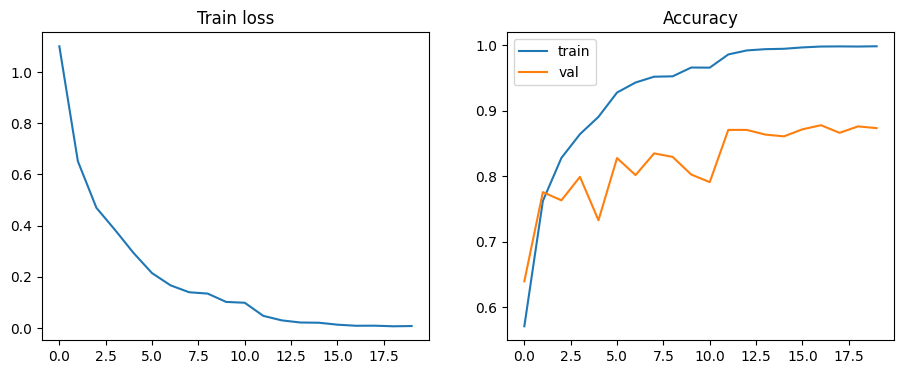


🏁  overall TEST accuracy: 85.765%
──────── per-class accuracy ────────
ANG: 86.76%  (177/204)
DIS: 88.18%  (179/203)
FEA: 77.09%  (138/179)
HAP: 96.43%  (189/196)
NEU: 83.75%  (134/160)
SAD: 80.57%  (141/175)


In [ ]:
import os, glob, torch, matplotlib.pyplot as plt
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
from torchvision.transforms import Compose, CenterCrop, RandomHorizontalFlip
from torchvision.transforms.functional import normalize
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import ApplyTransformToKey, UniformTemporalSubsample, ShortSideScale

# ──────────────── config ────────────────
VIDEO_DIR   = "/content/drive/MyDrive/crema_preprocessed"
EPOCHS      = 20
PATIENCE    = 5
BATCH_SIZE  = 16
LR          = 5e-5
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
LABELS      = sorted(os.listdir(VIDEO_DIR))
LABEL_MAP   = {l: i for i, l in enumerate(LABELS)}
INV_LABEL   = {v: k for k, v in LABEL_MAP.items()}
CKPT_PATH   = "/content/drive/MyDrive/best_crema_r2p1d.pt"

# ──────────────── transform ─────────────
video_tf = ApplyTransformToKey(
    key="video",
    transform=Compose([
        UniformTemporalSubsample(16),
        ShortSideScale(128),
        RandomHorizontalFlip(0.5),
        lambda x: x.permute(1,0,2,3),          # [C,T,H,W]→[T,C,H,W]
        CenterCrop(112),
        lambda x: x.permute(1,0,2,3),
        lambda x: x.float(),
        lambda x: torch.stack([
            normalize(f, [0.45]*3, [0.225]*3)
            for f in x.permute(1,0,2,3)
        ], dim=1)
    ])
)

# ─────────────── dataset ────────────────
class CREMAD(Dataset):
    def __init__(self, root, tf=None):
        self.samples, self.tf = [], tf
        for lbl in os.listdir(root):
            for f in glob.glob(os.path.join(root, lbl, "*.mp4")):
                self.samples.append((f, LABEL_MAP[lbl]))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        try:
            clip = EncodedVideo.from_path(path).get_clip(0, 2.0)["video"]/255.
        except Exception:
            clip = torch.zeros(3,16,112,112)
        sample = {"video": clip}
        if self.tf: sample = self.tf(sample)
        return sample["video"], lbl

full_ds = CREMAD(VIDEO_DIR, video_tf)

# ─────────── three-way split ────────────
torch.manual_seed(42)
n = len(full_ds)
train_n = int(0.70 * n)
val_n   = int(0.15 * n)
test_n  = n - train_n - val_n
train_ds, val_ds, test_ds = random_split(full_ds, [train_n, val_n, test_n])

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# ────────────── model ───────────────────
weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))
model = model.to(DEVICE)

opt  = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)
crit = nn.CrossEntropyLoss()

best_val = 0
pat_cnt  = 0
train_losses, train_accs, val_accs = [], [], []

# ──────────── training ──────────────────
for epoch in range(1, EPOCHS+1):
    # train
    model.train();  tr_loss = cor = tot = 0
    for x, y in train_ld:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out  = model(x);  loss = crit(out, y)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_loss += loss.item()
        cor += (out.argmax(1) == y).sum().item()
        tot += y.size(0)
    tr_loss /= len(train_ld); tr_acc = cor / tot
    train_losses.append(tr_loss); train_accs.append(tr_acc)

    # validate
    model.eval(); cor = tot = 0
    with torch.no_grad():
        for x, y in val_ld:
            x, y = x.to(DEVICE), y.to(DEVICE)
            cor += (model(x).argmax(1) == y).sum().item()
            tot += y.size(0)
    val_acc = cor / tot; val_accs.append(val_acc); sched.step(val_acc)

    print(f"Epoch {epoch:02d}: loss {tr_loss:.4f} | train {tr_acc:.3%} | val {val_acc:.3%}")

    if val_acc > best_val:
        best_val = val_acc; pat_cnt = 0
        torch.save(model.state_dict(), CKPT_PATH)
        print("   ✅ new best saved")
    else:
        pat_cnt += 1
        if pat_cnt >= PATIENCE:
            print("   ⏹ early stopping"); break

# ─────────────── curves ─────────────────
plt.figure(figsize=(11,4))
plt.subplot(1,2,1); plt.plot(train_losses); plt.title("Train loss")
plt.subplot(1,2,2); plt.plot(train_accs,label="train"); plt.plot(val_accs,label="val"); plt.title("Accuracy"); plt.legend(); plt.show()

# ─────────── reload best & test ─────────
best = r2plus1d_18(weights=None)
best.fc = nn.Linear(best.fc.in_features, len(LABELS))
best.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
best = best.to(DEVICE).eval()

tot = cor = 0
per_cls_tot = torch.zeros(len(LABELS))
per_cls_cor = torch.zeros(len(LABELS))

with torch.no_grad():
    for x, y in test_ld:
        x, y = x.to(DEVICE), y.to(DEVICE)
        p = best(x).argmax(1)
        cor += (p==y).sum().item();  tot += y.size(0)
        for yi, pi in zip(y, p):
            per_cls_tot[yi] += 1
            if yi == pi: per_cls_cor[yi] += 1

test_acc = cor / tot
print(f"\n🏁  overall TEST accuracy: {test_acc:.3%}")

print("──────── per-class accuracy ────────")
for i, lbl in enumerate(LABELS):
    if per_cls_tot[i]:
        acc = (per_cls_cor[i]/per_cls_tot[i]).item()*100
        print(f"{lbl:>3}: {acc:5.2f}%  ({int(per_cls_cor[i])}/{int(per_cls_tot[i])})")
